# Exercise2-1: MNIST Classification

# Import library

In [0]:
import numpy as np
import chainer
from chainer.cuda import to_cpu
from chainer import iterators, optimizers, training, serializers
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

# Dataset
* Total 70,000 hand-written digit images
* We divide 70,000 samples into 50,000 Training data, 10,000 Validation data, 10,000 Test data
* Each data is image-label pairs

In [2]:
from chainer.datasets import mnist
train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

print(len(train_val))
print(len(test))

60000
10000


In [3]:
from chainer.datasets import split_dataset_random
train, valid = split_dataset_random(train_val, 50000, seed=0)

print(len(train))
print(len(valid))

50000
10000


# Check MNIST data

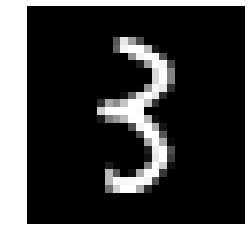

label: 3


In [4]:
x, t = train[0]  # 0th (data, label)
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', t)

# Prepare the model
* 2 Lyaer NN
* Input Unit: None (784 nodes)
* Midterm Unit: 100 nodes
* Output Unit: 10 noes

In [0]:
class MLP(chainer.Chain):
    def __init__(self):
        super(MLP, self).__init__()

        #  Initialization of layers
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(100, 10)

    def __call__(self, x):
        # Forward computation by __call__
        h1 = F.tanh(self.l1(x))
        y = self.l2(h1)
        return y


      
gpu_id = 0  # Set to -1 if you use CPU
      
model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

# Check initial weight  $b$
* Initial weight $b$ is zero

In [6]:
print('Bias parameter', model.l1.b.shape)

Bias parameter (100,)


In [7]:
print('Initialzation', model.l1.b.array)

Initialzation [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


# Check initial weight $W$
* Since None is assigned to Input Unit, initial weight $W$ is None

In [8]:
#print(model.l1.W.shape)
print(model.l1.W.array)

None


# MiniBatch
* batchsize=128
* optimizers.SGD(lr=0.01)
* max_epoch=5

In [0]:
# Data set
batchsize = 128

# Iterator
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# Model
net = L.Classifier(model, lossfun=F.softmax_cross_entropy)

# Optimizar
optimizer = optimizers.SGD(lr=0.01).setup(net)

# Updater
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# Trainer
max_epoch = 5
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

# Trainer extensions
trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(valid_iter, net, device=gpu_id), name='val')
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))   

# Start Training

In [10]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.31938     0.716532       0.83966        0.827532           10.559        
2           0.693449    0.848765       0.591469       0.863232           12.5615       
3           0.53758     0.870573       0.495807       0.87678            14.5549       
4           0.465969    0.881054       0.44453        0.883703           16.5684       
5           0.424859    0.887508       0.411737       0.888647           18.5848       


# Plot: Loss and Accurary

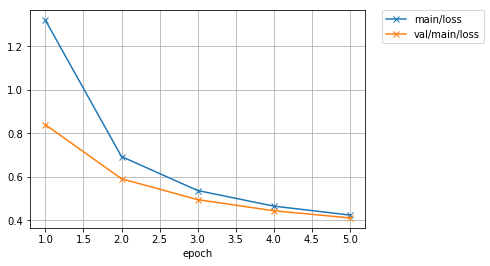

In [11]:
Image(filename='mnist_result/loss.png')

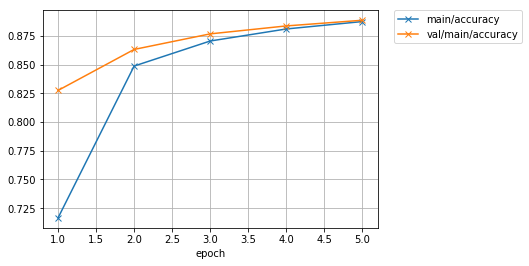

In [12]:
Image(filename='mnist_result/accuracy.png')

# Accuracy 88%

# Evaluate a trained model

In [0]:
infer_net = MLP()
serializers.load_npz('mnist_result/snapshot_epoch-5',infer_net, path='updater/model:main/predictor/')

#  Correctly classifed data

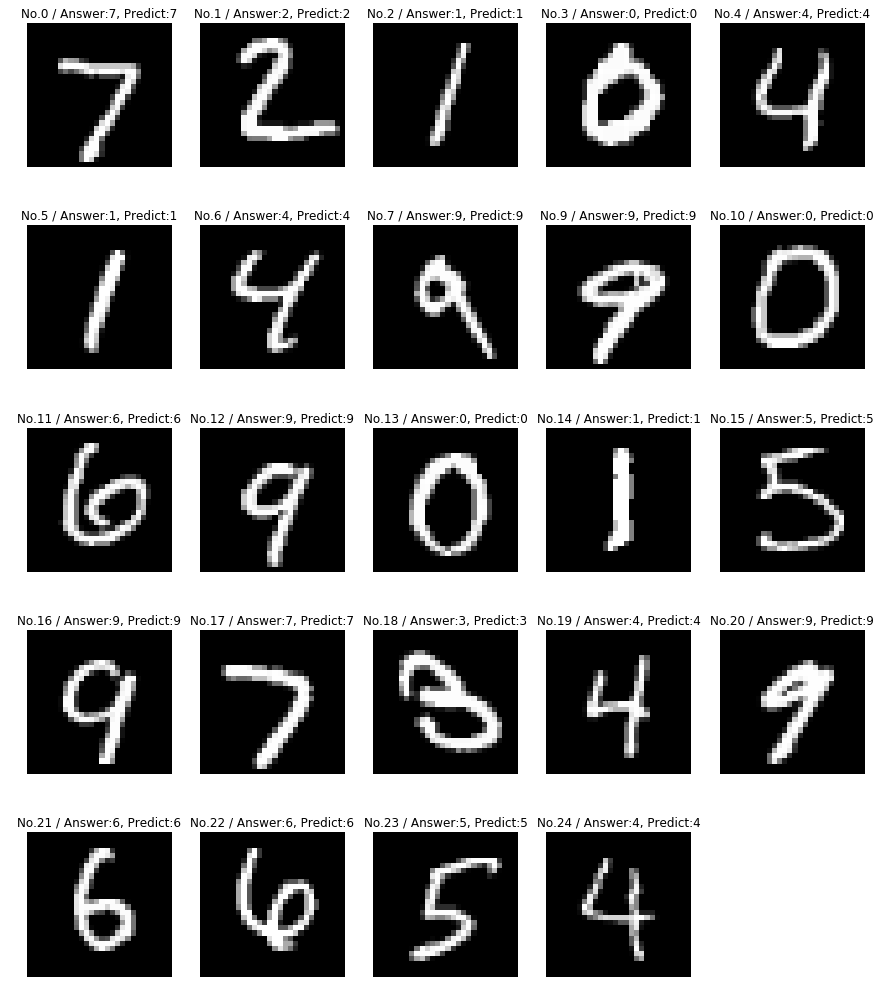

In [14]:
plt.figure(figsize=(15,18))
k=0

for i in range(40):
    x, t = test[i]
    x = x[None, ...]
    
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y = infer_net(x)
    y = to_cpu(y.array)
    y_pred = y.argmax(axis=1)[0]
    if y_pred == t:
        k=k+1
        if k>=25: break
        plt.subplot(5, 5, k)
        plt.imshow(x.reshape(28, 28), cmap='gray')
        plt.axis("off")
        plt.title("No.{0} / Answer:{1}, Predict:{2}".format(i, t, y_pred))

#  Not Correctly classifed data

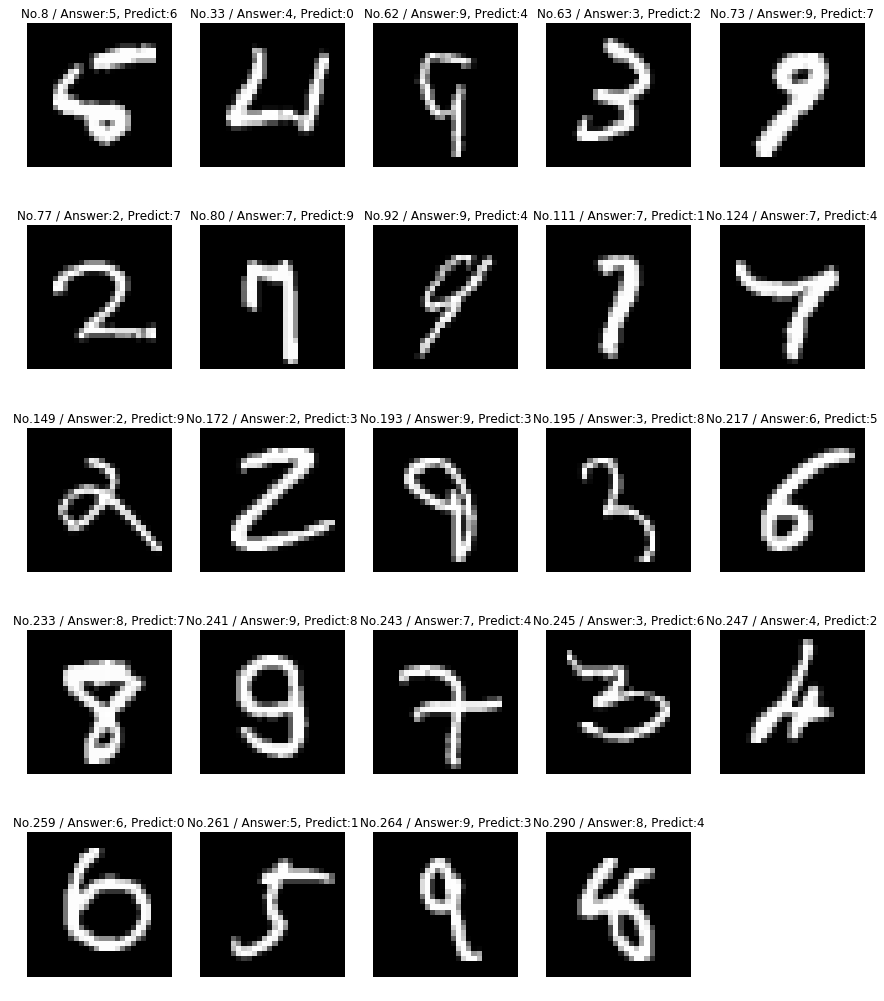

In [15]:
plt.figure(figsize=(15,18))
k=0

for i in range(1000):
    x, t = test[i]
    x = x[None, ...]
    
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y = infer_net(x)
    y = to_cpu(y.array)
    y_pred = y.argmax(axis=1)[0]
    if y_pred != t:
        k=k+1
        if k>=25: break
        plt.subplot(5, 5, k)
        plt.imshow(x.reshape(28, 28), cmap='gray')
        plt.axis("off")
        plt.title("No.{0} / Answer:{1}, Predict:{2}".format(i, t, y_pred))


# Check Other Hyper parameter
* Change Activation Function F.tanh, F.relu, F.sigmoid, F.leaky_relu 
* Change Midterm Layer Node
* optimizers.SGD, optimizers.Adam, optimizers.RMSprop
* lr=0.01 (learnig rate)